# Chapter 7. 토픽 모델링으로 주제 찾기

## 1. 토픽 모델링의 이해

1: https://mobile.newsis.com/view.html?ar_id=NISX20190918_0000772783#_enliple
2: https://cyram.tistory.com/309

### 1.1 LDA(Latent Dirichlet Allocation)



### 1.2 모형의 평가와 적절한 토픽 수의 결정


## 2. 사이킷런을 이용한 토픽 모델링

### 2.1 데이터 준비



In [1]:
import nltk
nltk.download('punkt')
nltk.download('webtext')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\delta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\delta\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\delta\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\delta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\delta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

#학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('#Train set size:', len(newsgroups_train.data))
print('#Selected categories:', newsgroups_train.target_names)

#Train set size: 3219
#Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\\w']{3,}", stop_words='english', 
                     max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

### 2.2 LDA 토픽 모델링 실행


1: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html <br>
2: Griffiths, Thomas L., and Mark Steyvers. "Finding scientific topics." Proceedings of the National academy of Sciences 101.suppl 1 (2004): 5228-5235.

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components = 10, #추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs= -1, #사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('#shape of review_topics:', review_topics.shape)
print('#Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('#Sum of topic weights of documents:', gross_topic_weights)

print('#shape of topic word distribution:', lda.components_.shape)

#shape of review_topics: (3219, 10)
#Sample of review_topics: [0.903 0.007 0.027 0.008 0.007 0.008 0.007 0.007 0.007 0.018]
#Sum of topic weights of documents: [0.087 0.083 0.085 0.115 0.115 0.126 0.098 0.072 0.07  0.148]
#shape of topic word distribution: (10, 2000)


In [5]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        #print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda,cv.get_feature_names_out(), 10)

Topic #0: com, morality, keith, article, sgi, think, sandvik, objective, caltech, moral
Topic #1: image, file, graphics, files, ftp, available, software, use, data, mail
Topic #2: space, nasa, access, launch, earth, orbit, shuttle, digex, lunar, satellite
Topic #3: article, com, just, don't, like, i'm, nntp, university, host, posting
Topic #4: key, clipper, chip, encryption, com, government, law, keys, use, escrow
Topic #5: scsi, com, bit, ibm, bus, know, windows, thanks, card, university
Topic #6: host, gov, nntp, posting, university, distribution, nasa, ___, world, com
Topic #7: drive, com, disk, hard, controller, drives, dos, tape, floppy, problem
Topic #8: key, public, message, faq, mail, pgp, des, group, uni, ripem
Topic #9: god, people, don't, jesus, believe, just, does, say, think, know



### 2.3 최적의 토픽 수 선택하기


n_components: 6, perplexity: 1058.260
n_components: 7, perplexity: 1055.111
n_components: 8, perplexity: 1018.328
n_components: 9, perplexity: 1017.749
n_components: 10, perplexity: 1028.686
n_components: 11, perplexity: 1033.398
n_components: 12, perplexity: 1032.112
n_components: 13, perplexity: 1038.642
n_components: 14, perplexity: 1038.627
n_components: 15, perplexity: 1044.712


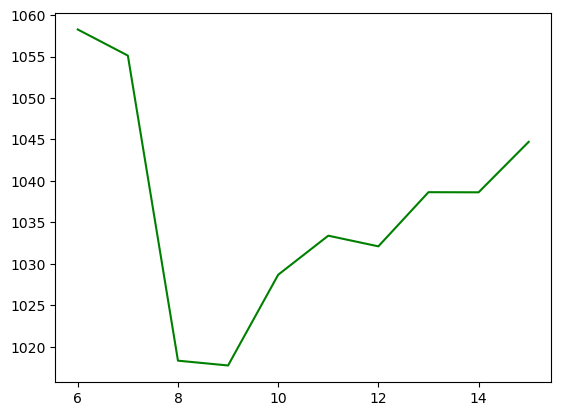

9

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [7]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: image, graphics, available, file, mail, ftp, data, information, files, software
Topic #1: posting, nntp, host, com, university, gov, distribution, article, nasa, ___
Topic #2: com, keith, article, morality, think, caltech, sgi, don't, objective, posting
Topic #3: com, jesus, article, know, god, just, don't, people, good, sandvik
Topic #4: people, god, does, don't, think, say, believe, just, like, way
Topic #5: drive, scsi, card, com, disk, ide, controller, hard, bus, use
Topic #6: space, nasa, access, launch, moon, year, article, digex, just, earth
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



## 3. Gensim을 이용한 토픽 모델링


### 3.1 Gensim 사용법과 시각화

1: https://radimrehurek.com/gensim/

In [ ]:
# !pip install --upgrade gensim

   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   - -------------------------------------- 0.8/24.0 MB 4.2 MB/s eta 0:00:06
   --- ------------------------------------ 1.8/24.0 MB 4.6 MB/s eta 0:00:05
   ---- ----------------------------------- 2.9/24.0 MB 4.7 MB/s eta 0:00:05
   ------ --------------------------------- 3.7/24.0 MB 4.6 MB/s eta 0:00:05
   ------- -------------------------------- 4.7/24.0 MB 4.6 MB/s eta 0:00:05
   --------- ------------------------------ 5.8/24.0 MB 4.6 MB/s eta 0:00:04
   ---------- ----------------------------- 6.3/24.0 MB 4.6 MB/s eta 0:00:04
   ----------- ---------------------------- 7.1/24.0 MB 4.2 MB/s eta 0:00:04
   ------------- -------------------------- 8.1/24.0 MB 4.3 MB/s eta 0:00:04
   -------------- ------------------------- 8.9/24.0 MB 4.3 MB/s eta 0:00:04
   ---------------- ----------------------- 10.0/24.0 MB 4.4 MB/s eta 0:00:04
   ------------------ --------------------- 11.0/24.0 MB 4.4 MB/s eta 0:00:03
   -

In [ ]:
# 필요한 library들을 import
from nltk.corpus import stopwords
cachedStopWords = stopwords.words("english")

from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{3,}") # 정규표현식으로 토크나이저를 정의
english_stops = set(stopwords.words('english')) #영어 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text.lower()) 
    # stopwords 제외
    words = [word for word in tokens if (word not in english_stops) and len(word) > 2]
    return words

texts = [tokenizer(news) for news in newsgroups_train.data]

1: https://radimrehurek.com/gensim/corpora/dictionary.html

In [ ]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

1: https://radimrehurek.com/gensim/models/ldamodel.html 

In [ ]:
from gensim.models import LdaModel

num_topics = 10
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

In [ ]:
model.print_topics(num_words=10)

In [ ]:
print("#topic distribution of the first document: ", model.get_document_topics(corpus)[0])

In [ ]:
#!pip install pyldavis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(model, corpus, dictionary)
lda_viz

### 3.2 혼란도와 토픽 응집도를 이용한 최적값 선택

https://radimrehurek.com/gensim/models/coherencemodel.html

In [ ]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

In [ ]:
def show_coherence(corpus, dictionary, start=6, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=6, end=15)

## 4. 토픽트렌드로 시간에 따른 주제의 변화 알아내기

1: https://github.com/akngs/petitions

In [ ]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") #read data
df.head(1)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc):
    return [token for token in twit.nouns(doc) if len(token) > 1]

vec = CountVectorizer(tokenizer=tokenizer, #우선은 명사만 사용
                      max_df=0.5, min_df = 5, 
                      max_features = 1000) #적당한 대상 단어 수를 선택

pet_cv = vec.fit_transform(df.content)
print(pet_cv.shape)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components = 15, \
                                n_jobs= -1, \
                                random_state=0)

%time pet_topics = lda.fit_transform(pet_cv)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
print_top_words(lda,vec.get_feature_names(), 10)

In [ ]:
trend_data = pd.DataFrame(pet_topics, columns=['Topic'+str(i) for i in range(1, 16)])
trend_data = pd.concat([trend_data, df.start.map(lambda x: x[:7])], axis=1)
trend_data.iloc[:5, -5:]

In [ ]:
trend = trend_data.groupby(['start']).mean()
trend.iloc[:5, -5:]

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(5, 3, sharex='col', figsize=(12, 16)) 
for col, ax in zip(trend.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend[col])
plt.show()

## 5. 동적 토픽 모델링(Dynamic Topic Modeling)

In [ ]:
import pandas as pd

df = pd.read_csv("./data/petition_sampled.csv") 
df_sorted = df.sort_values(by='start') # 문서를 시작날짜 순으로 정렬

# time slice를 생성. 월별로 변화를 보기 위해 연도와 월만 추출하여 time 열 생성
df_sorted['time'] = df_sorted['start'].map(lambda x: x[:7])

# 각 월별로 문서가 몇건인지를 계산하여 time_slice에 저장
time_slice = list(df_sorted['time'].value_counts().sort_index())
print(time_slice, sum(time_slice))

In [ ]:
# 시간 구간을 리스트로 작성
time_tag = sorted(list(set(df_sorted['time'])))
print(time_tag)

In [ ]:
from gensim.corpora.dictionary import Dictionary
from konlpy.tag import Okt #konlpy에서 Twitter 형태소 분석기를 import
twit = Okt()

def tokenizer(doc): #명사만 사용
    return [token for token in twit.nouns(doc) if len(token) > 1]

#청원데이터의 텍스트를 토큰화
texts = [tokenizer(news) for news in df_sorted['content']]

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts) 
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n = 2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

In [ ]:
# 적절한 토픽의 수를 알아보기 위해 토픽수를 바꿔가면서 log_perplexity와 coherence를 계산
from gensim.models import CoherenceModel

coherence = cm.get_coherence()
show_coherence(corpus, dictionary, start=6, end=15)

In [ ]:
# LdaSeqModel를 실행
from gensim.models import LdaSeqModel
import warnings
warnings.filterwarnings("ignore")

#시간이 많이 소요됨
ldaseq = LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=6, random_state=7)

In [ ]:
# 토픽결과로부터 상위 n개의 단어만 반환하는 함수 작성
def get_topic_words(topic, top_n_words=10):
    words, _ = zip(*topic)
    return words[:top_n_words]

# 주어진 토픽에 대해 시간별로 상위단어를 간략하게 출력하는 함수 작성
def print_topic_times(model, topic, time_tag, top_n_words=10):
    topic_times = model.print_topic_times(topic)
    for i in range(len(topic_times)):
        print(time_tag[i]+':', get_topic_words(topic_times[i], top_n_words))

In [ ]:
# 4번 토픽에 대해 시간 별로 상위 8개의 단어를 출력
print_topic_times(ldaseq, 4, time_tag, 8)

In [ ]:
# 구간별로 문서 토픽 분포의 평균을 구하여 토픽의 트렌드로 사용
def get_topic_trends(model, corpus, time_slice):
    dtm = model.dtm_vis(0, corpus) #dtm_vis 메서드를 이용해 문서별 토픽분포를 가져옴
    result = []
    start = 0
    for index in time_slice: # 각 구간별 문서들에 대해 토픽분포의 평균을 구함
        result.append(np.array(dtm[0][start:start+index]).mean(axis=0))
        start += index
    return np.array(result)
topic_trends = get_topic_trends(ldaseq, corpus, time_slice)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

topic_titles = ['Topic '+str(i) for i in range(6)] # 토픽 타이틀 생성
fig, axes = plt.subplots(2, 3, sharex='col', figsize=(12, 6)) 
for i, (title, ax) in enumerate(zip(topic_titles, axes.ravel())): 
    ax.set_title(title)
    ax.set_xticks([0, 5, 10, 15])
    ax.set_xticklabels(time_tag[::5])
    ax.plot(topic_trends[:, i])
plt.savefig('dtm.png')
plt.show()

In [ ]:
import pyLDAvis
pyLDAvis.enable_notebook()

# 특정 time slice의 토픽분포를 시각화 - ldaseq.dtm_vis() 메서드를 이용
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm) #결과를 출력
#pyLDAvis.save_html(vis_dtm, 'lda_time0.html')) #결과를 별도의 html 파일로 저장

In [ ]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=1, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)
#pyLDAvis.save_html(vis_dtm, 'lda_time1.html')